In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("NRELs Charging Data - Raw.csv", sep=',')
df.head()

,driverId,vehicle_model,request_entry_time,expected_departure,station,start_date_time,end_date_time,start_charge,termin_charge,controlled_duration,miles_requested,max_charge_power,kwh_requested,energy_charged,cost_for_session,afterPaid
0,0,Nissan LEAF,2016-11-03 10:01:03,2016-11-03 16:30:00,10B,NaN,NaN,NaN,NaN,NaN,35,NaN,10.5,NaN,NaN,False
1,0,Nissan LEAF,2016-11-03 10:12:35,2016-11-03 16:30:00,10A,NaN,NaN,NaN,NaN,NaN,35,NaN,10.5,NaN,NaN,False
2,0,Mitsubishi iMiEV,2016-11-03 10:18:11,2016-11-03 16:00:00,03A,NaN,NaN,NaN,NaN,NaN,25,NaN,7.5,NaN,NaN,False
3,0,Chevy Volt,2016-11-03 11:06:13,2016-11-03 13:00:00,15B,NaN,NaN,2016-11-03 10:45:00,2016-11-03 11:00:00,NaN,40,1.538424,14.0,2.994376,0.299438,False
4,0,Chevy Volt,2016-11-03 11:19:17,2016-11-03 17:00:00,04B,NaN,NaN,NaN,NaN,NaN,50,NaN,17.5,NaN,NaN,False


### ========================= Data Preparation =========================

In [3]:
#Null Values
print(f"df shape: {df.shape}")
df.isnull().sum()

df shape: (40979, 16)


driverId                   0
vehicle_model           7580
request_entry_time         0
expected_departure         0
station                    0
start_date_time        26391
end_date_time          26391
start_charge            4373
termin_charge           4373
controlled_duration    36216
miles_requested            0
max_charge_power        4373
kwh_requested              0
energy_charged           487
cost_for_session         487
afterPaid                  0
dtype: int64

In [4]:
# The data column that will be used is "request_entry_time"
# The column that will be predicted is "energy_charged"
# We will divide tha dataset by "station"

df = df[['request_entry_time', 'energy_charged', 'station']]
display(df.head())
df.isnull().sum()

,request_entry_time,energy_charged,station
0,2016-11-03 10:01:03,NaN,10B
1,2016-11-03 10:12:35,NaN,10A
2,2016-11-03 10:18:11,NaN,03A
3,2016-11-03 11:06:13,2.994376,15B
4,2016-11-03 11:19:17,NaN,04B


request_entry_time      0
energy_charged        487
station                 0
dtype: int64

In [5]:
# In timseries_car_dataset notebook we dropped the null values. Now, we will fill the null values.

#In this case, we will fill the null based the avarage value of the dataset 
df['energy_charged'].fillna(df['energy_charged'].mean(), inplace=True)

df.isnull().sum()

request_entry_time    0
energy_charged        0
station               0
dtype: int64

In [6]:
# request_entry_time --- object --> datetime

df['request_entry_time'] = df['request_entry_time'].str.split(' ').str[0]
df["request_entry_time"] = pd.to_datetime(df["request_entry_time"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40979 entries, 0 to 40978
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   request_entry_time  40979 non-null  datetime64[ns]
 1   energy_charged      40979 non-null  float64       
 2   station             40979 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 960.6+ KB


In [7]:
# The dataset has more than 140 different stations 0_0
# We will not plot the final model to all of then, it would be so much plots and tiring to see

len(set(df['station']))

141

In [8]:
for station in df['station'].unique():
    print(f"{station} --", df[df["station"]==station].shape)

# 02A 07B 07A 06A 03B 08B 01B 02B 04A 08A 03A 12B 01A 06B 05A 14A -- 800+ records

10B -- (745, 3)
10A -- (791, 3)
03A -- (857, 3)
15B -- (753, 3)
04B -- (705, 3)
12B -- (802, 3)
02A -- (910, 3)
07B -- (953, 3)
11B -- (738, 3)
07A -- (989, 3)
12A -- (762, 3)
17A -- (751, 3)
06A -- (982, 3)
03B -- (915, 3)
01A -- (821, 3)
05B -- (789, 3)
08B -- (1046, 3)
06B -- (848, 3)
01B -- (1206, 3)
02B -- (960, 3)
18B -- (643, 3)
15A -- (678, 3)
05A -- (835, 3)
04A -- (901, 3)
09A -- (713, 3)
17B -- (641, 3)
14B -- (703, 3)
09B -- (664, 3)
14A -- (824, 3)
18A -- (655, 3)
08A -- (1079, 3)
16B -- (643, 3)
11A -- (735, 3)
13B -- (728, 3)
16A -- (630, 3)
13A -- (718, 3)
LV21-05 -- (201, 3)
LV22-18 -- (196, 3)
LV21-12 -- (129, 3)
LV22-04 -- (403, 3)
LV22-08 -- (263, 3)
LV22-11 -- (285, 3)
LV22-01 -- (296, 3)
LV21-10 -- (174, 3)
LV21-15 -- (140, 3)
LV22-09 -- (212, 3)
LV21-13 -- (148, 3)
LV21-09 -- (166, 3)
LV22-03 -- (230, 3)
LV22-02 -- (563, 3)
LV21-01 -- (230, 3)
LV21-06 -- (143, 3)
LV21-11 -- (136, 3)
LV21-03 -- (220, 3)
LV22-05 -- (327, 3)
LV21-02 -- (207, 3)
LV22-10 -- (415, 3)
L

In [9]:
# Stations that we will use
stations = ["02A", '07B', '07A', "06A", '03B', "08B", "01B", "02B", "04A", "08A", "03A", "12B", "01A", "06B", "05A", "14A"]

df = df[df['station'].isin(stations)]
df['station'].unique()

array(['03A', '12B', '02A', '07B', '07A', '06A', '03B', '01A', '08B',
       '06B', '01B', '02B', '05A', '04A', '14A', '08A'], dtype=object)

In [10]:
#Creating a dataframe for each station and filtering a column of the total energy_charged
time_series_df = {}

for id in df['station'].unique():
    df_by_id = df[df['station'] == id]
    df_by_id = pd.DataFrame(df_by_id.groupby(df_by_id['request_entry_time'].dt.date)['energy_charged'].sum())
    df_by_id['station'] = id
    
    time_series_df[id] = df_by_id

In [11]:
time_series_df['12B'] #just checking with 1 example 

,energy_charged,station
request_entry_time,,
2016-11-04,7.877445,12B
2016-11-08,9.529669,12B
2016-11-11,8.954097,12B
2016-11-15,6.909706,12B
2016-11-16,4.001842,12B
...,...,...
2019-05-17,36.650736,12B
2019-05-20,20.973209,12B
2019-05-21,8.236082,12B


In [29]:
#create 7 day moving average to smooth out the data for prophet
for id in time_series_df.keys():
    time_series_df[id]['7dma'] = time_series_df[id]['energy_charged'].rolling(30).mean()
    time_series_df[id].dropna(inplace=True)


### ======================= TimeSeries - PROPHET =======================

In [30]:
#Prophet model requires you to change the name of the time data for "ds" and the target data for "y"
def prophet_ts(df):
    df = df.reset_index()
    df_prophet = df[['request_entry_time', 'energy_charged']]
    df_prophet.rename(columns={'request_entry_time':'ds',
                       'energy_charged':'y'}, inplace=True)
    
    #data column to datatime type
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
    print(f"data shape: {df_prophet.shape}")
    #Prophet model
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True) 
    model.add_country_holidays(country_name='US') #data are maintained by National Renewable Energy Lab (US)
    model.fit(df_prophet)

    #Dataframe for predictions
    future = model.make_future_dataframe(periods=250) #250 days
    forecast = model.predict(future)

    #plot
    fig = model.plot(forecast)
    plt.title(f'PREDICTION ELETRECITY (khw) - EV CHARGING - {df.station[1]} STATION')
    plt.xlabel('Data')
    plt.ylabel('kwh')
    plt.show()

21:41:12 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1] done processing


data shape: (585, 2)


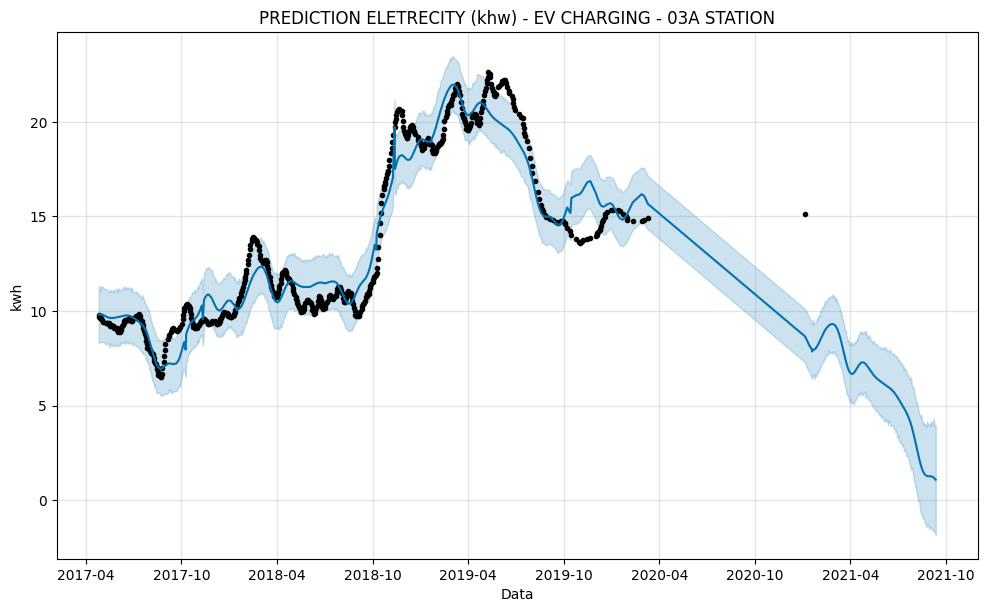

21:41:13 - cmdstanpy - INFO - Chain [1] start processing


data shape: (487, 2)


21:41:13 - cmdstanpy - INFO - Chain [1] done processing


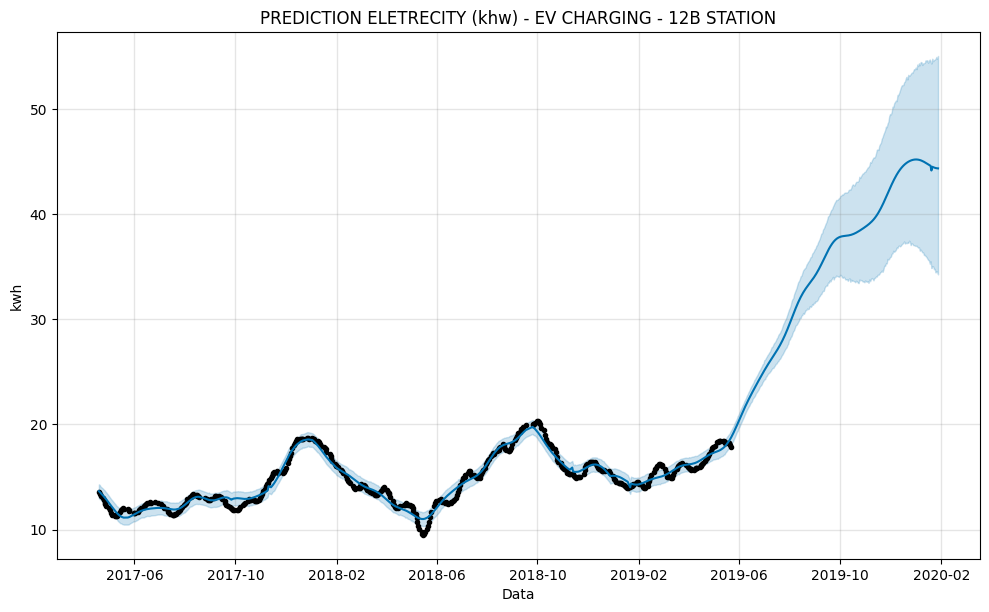

21:41:14 - cmdstanpy - INFO - Chain [1] start processing
21:41:14 - cmdstanpy - INFO - Chain [1] done processing


data shape: (603, 2)


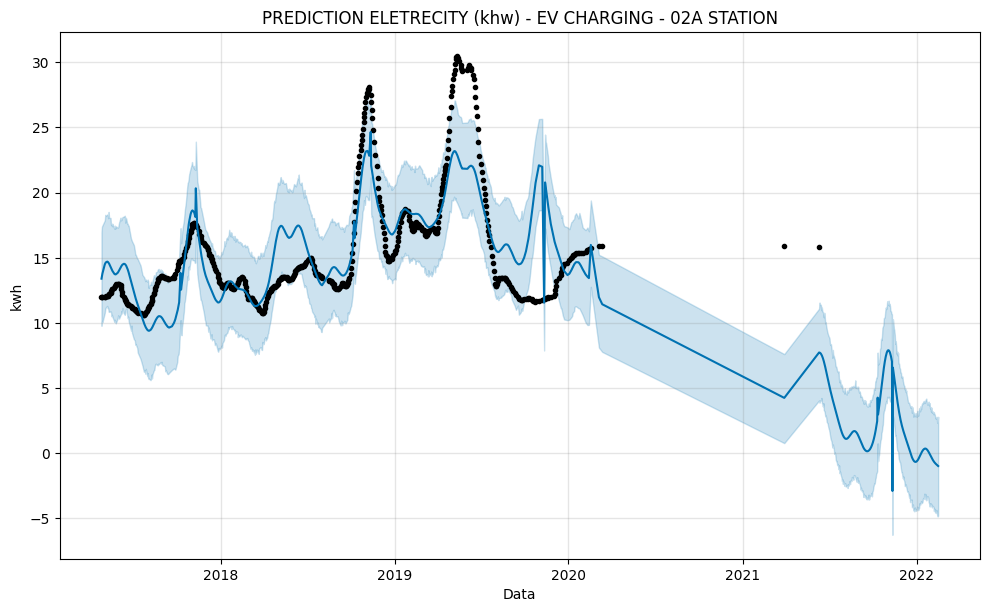

21:41:15 - cmdstanpy - INFO - Chain [1] start processing
21:41:15 - cmdstanpy - INFO - Chain [1] done processing


data shape: (654, 2)


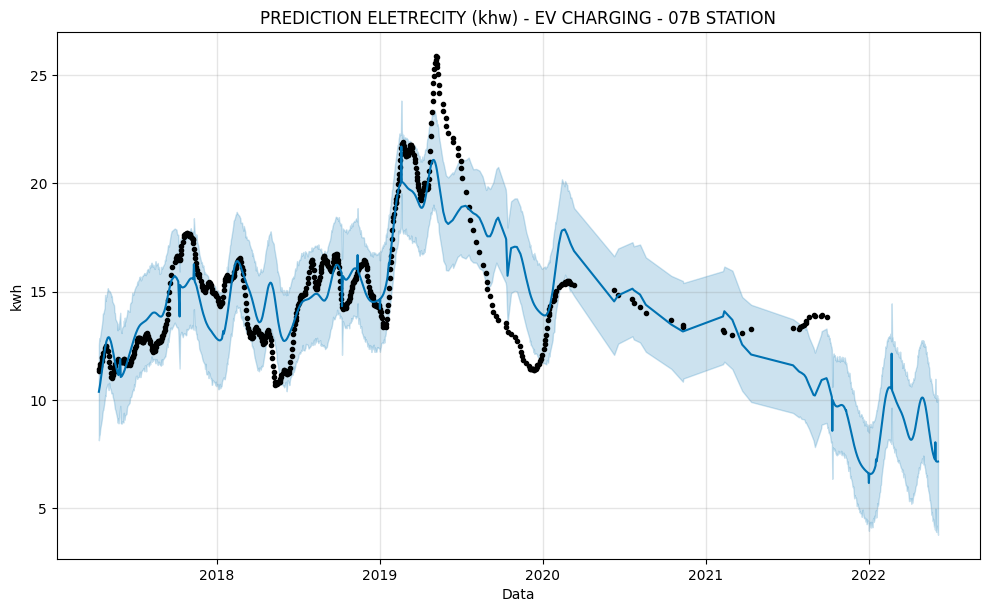

21:41:16 - cmdstanpy - INFO - Chain [1] start processing


data shape: (691, 2)


21:41:16 - cmdstanpy - INFO - Chain [1] done processing


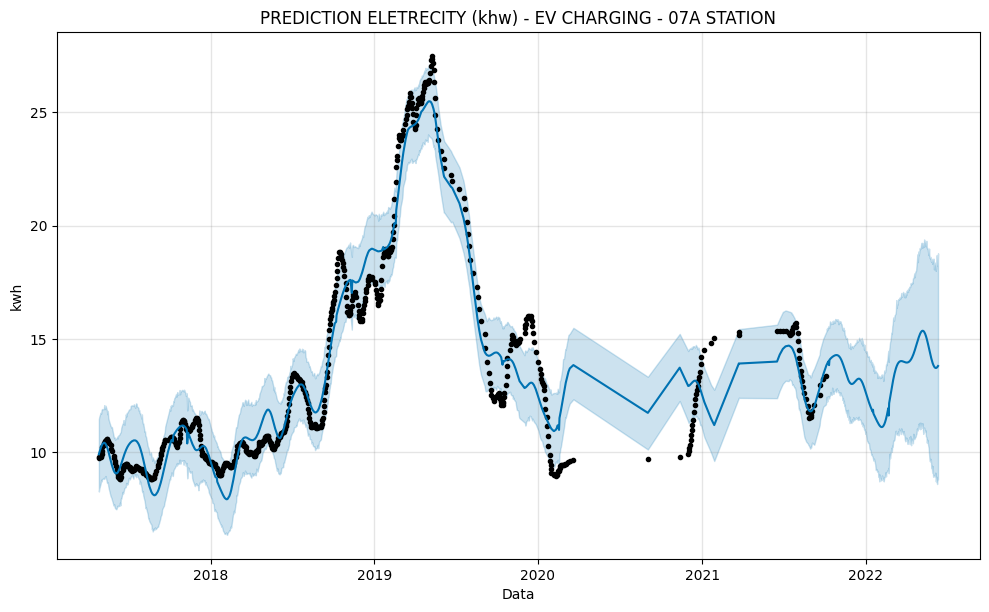

21:41:17 - cmdstanpy - INFO - Chain [1] start processing


data shape: (680, 2)


21:41:17 - cmdstanpy - INFO - Chain [1] done processing


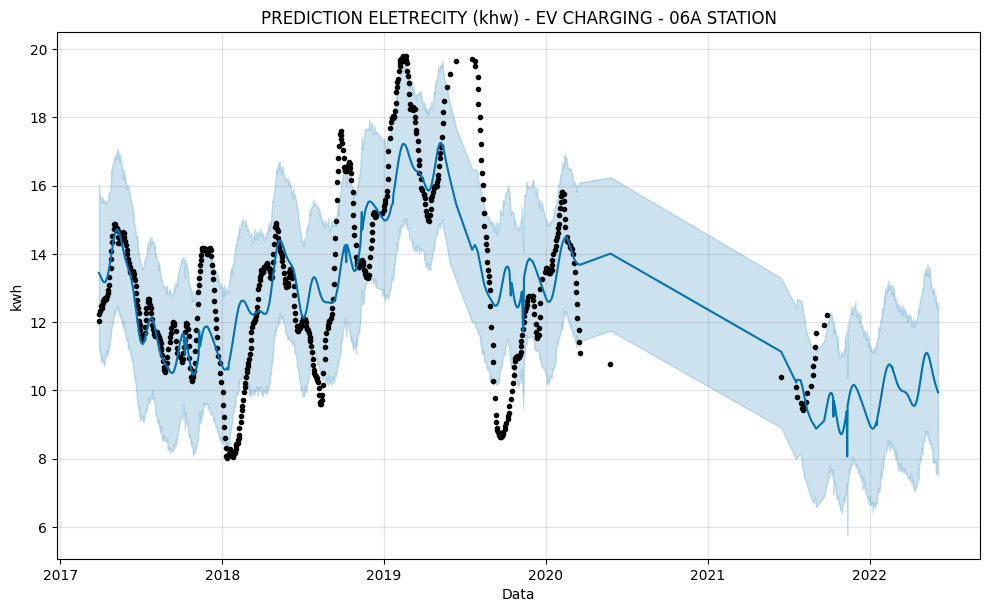

21:41:18 - cmdstanpy - INFO - Chain [1] start processing
21:41:18 - cmdstanpy - INFO - Chain [1] done processing


data shape: (611, 2)


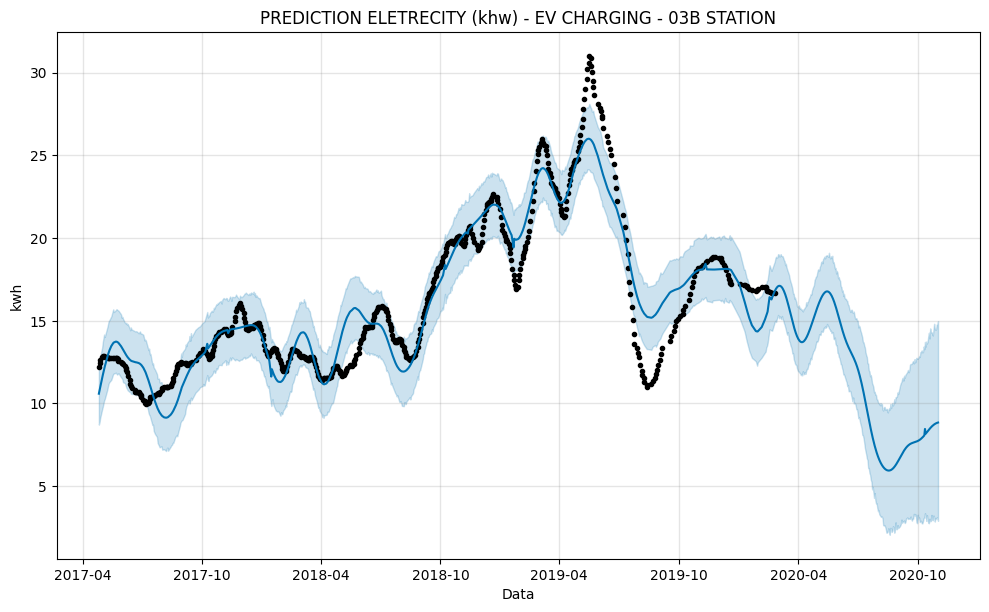

21:41:19 - cmdstanpy - INFO - Chain [1] start processing


data shape: (601, 2)


21:41:19 - cmdstanpy - INFO - Chain [1] done processing


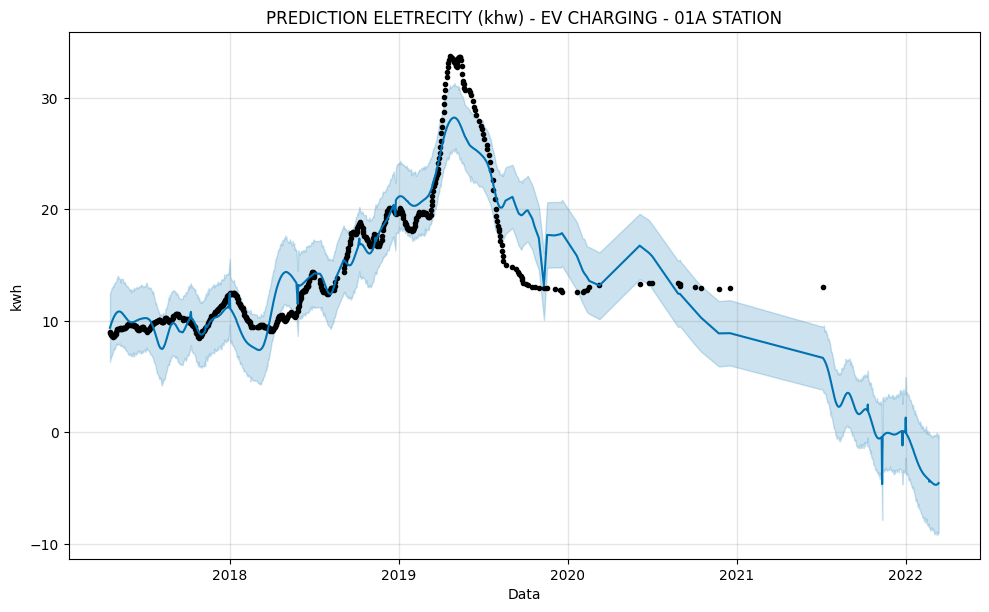

21:41:20 - cmdstanpy - INFO - Chain [1] start processing


data shape: (747, 2)


21:41:20 - cmdstanpy - INFO - Chain [1] done processing


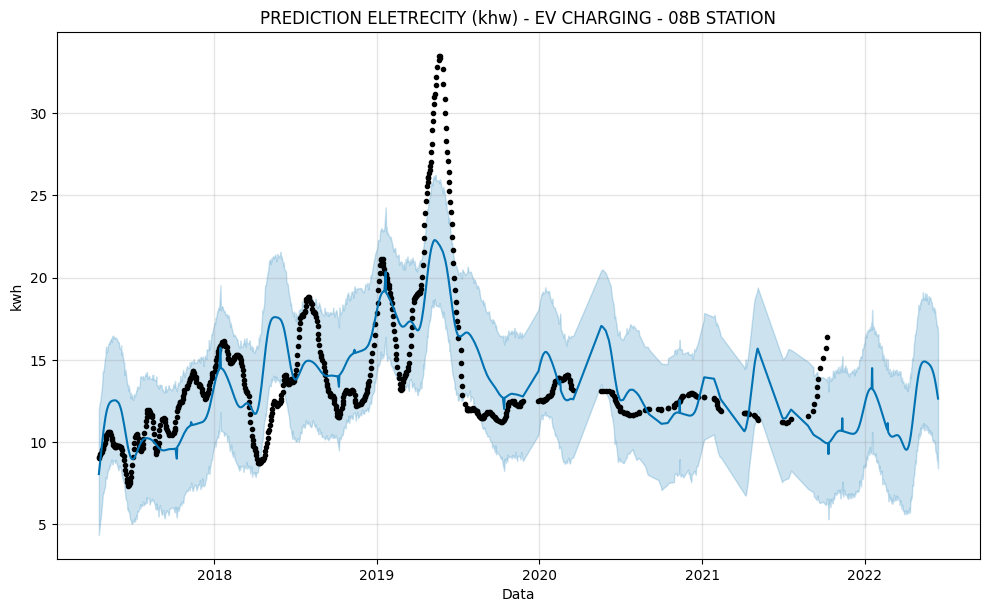

21:41:21 - cmdstanpy - INFO - Chain [1] start processing


data shape: (600, 2)


21:41:21 - cmdstanpy - INFO - Chain [1] done processing


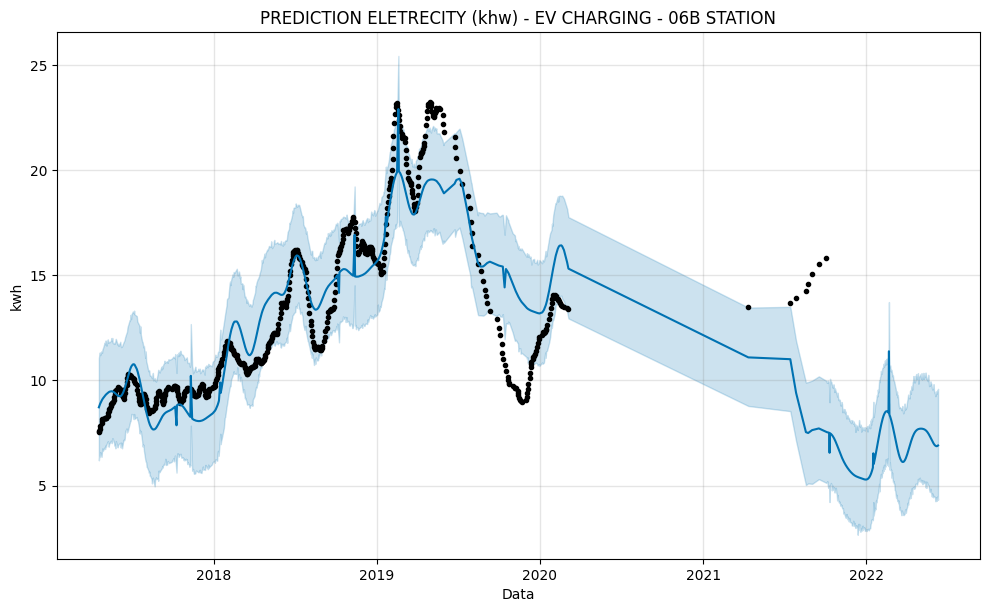

21:41:22 - cmdstanpy - INFO - Chain [1] start processing


data shape: (780, 2)


21:41:22 - cmdstanpy - INFO - Chain [1] done processing


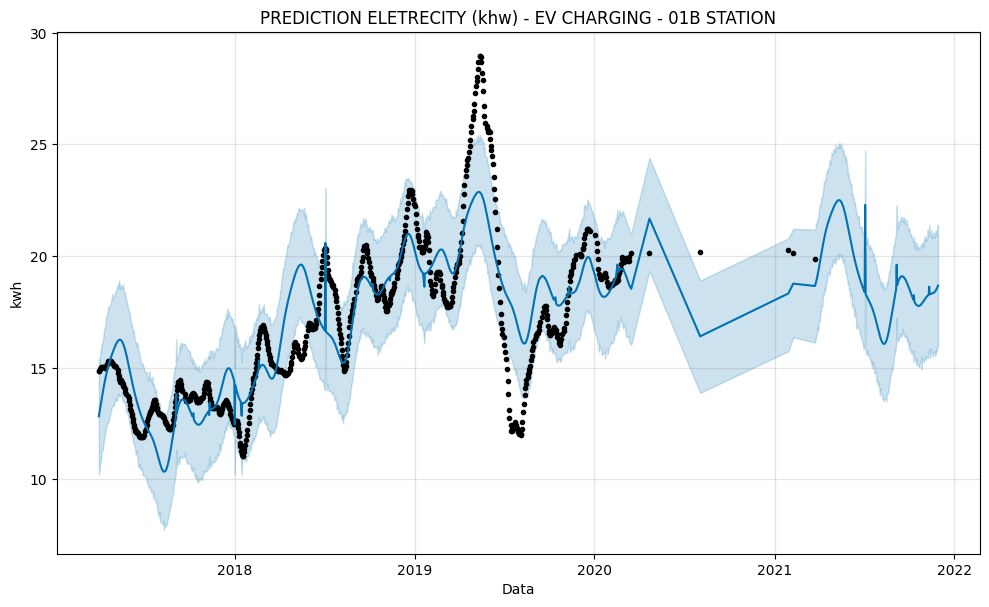

21:41:23 - cmdstanpy - INFO - Chain [1] start processing
21:41:23 - cmdstanpy - INFO - Chain [1] done processing


data shape: (696, 2)


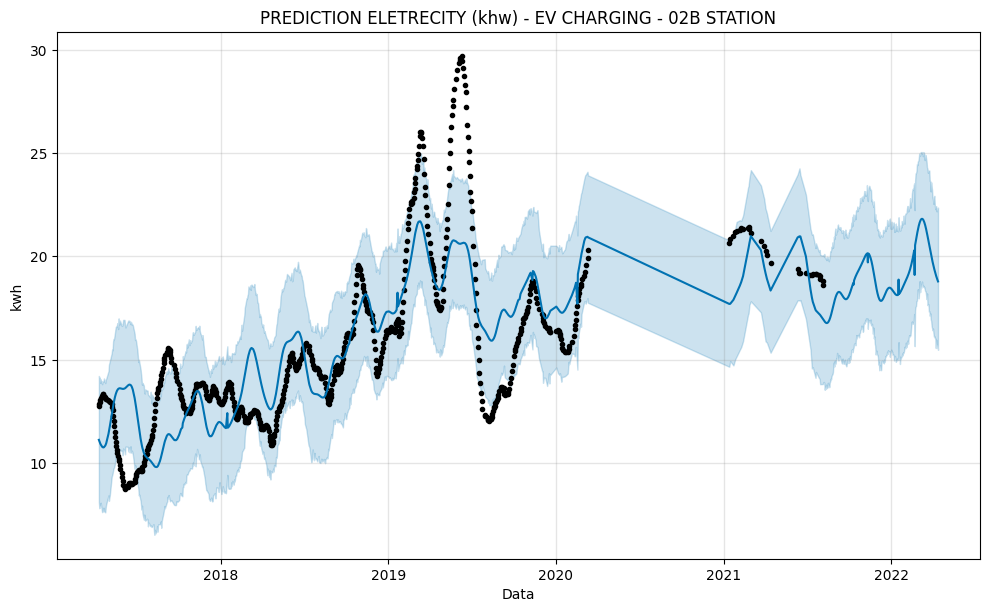

21:41:24 - cmdstanpy - INFO - Chain [1] start processing


data shape: (596, 2)


21:41:24 - cmdstanpy - INFO - Chain [1] done processing


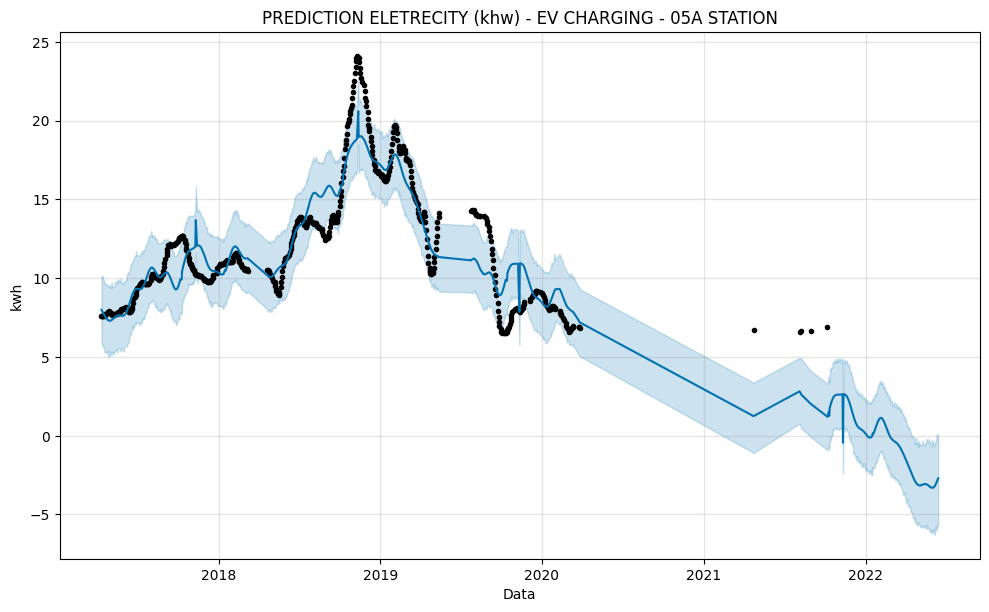

21:41:25 - cmdstanpy - INFO - Chain [1] start processing


data shape: (574, 2)


21:41:25 - cmdstanpy - INFO - Chain [1] done processing


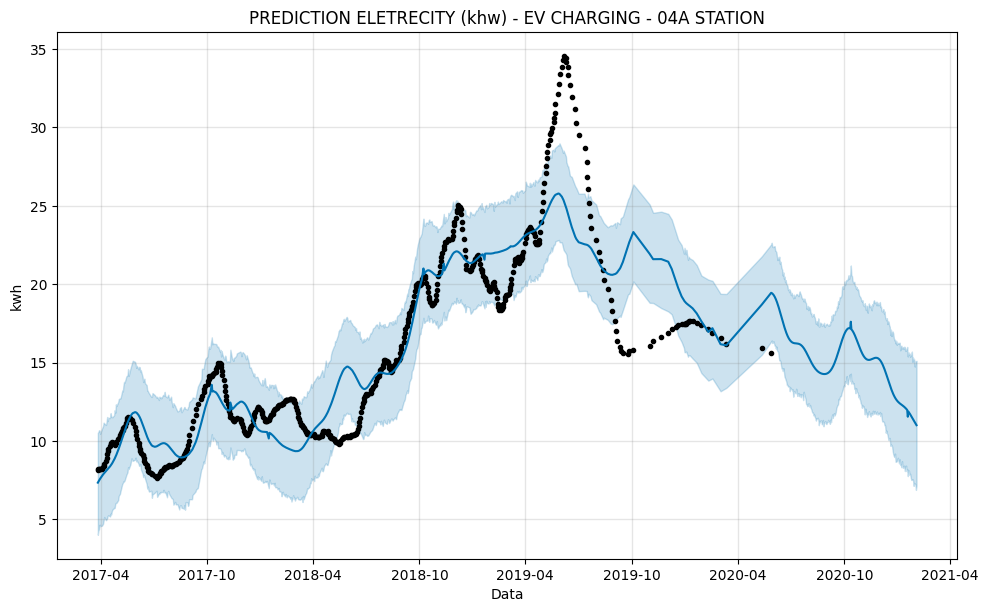

21:41:25 - cmdstanpy - INFO - Chain [1] start processing
21:41:25 - cmdstanpy - INFO - Chain [1] done processing


data shape: (508, 2)


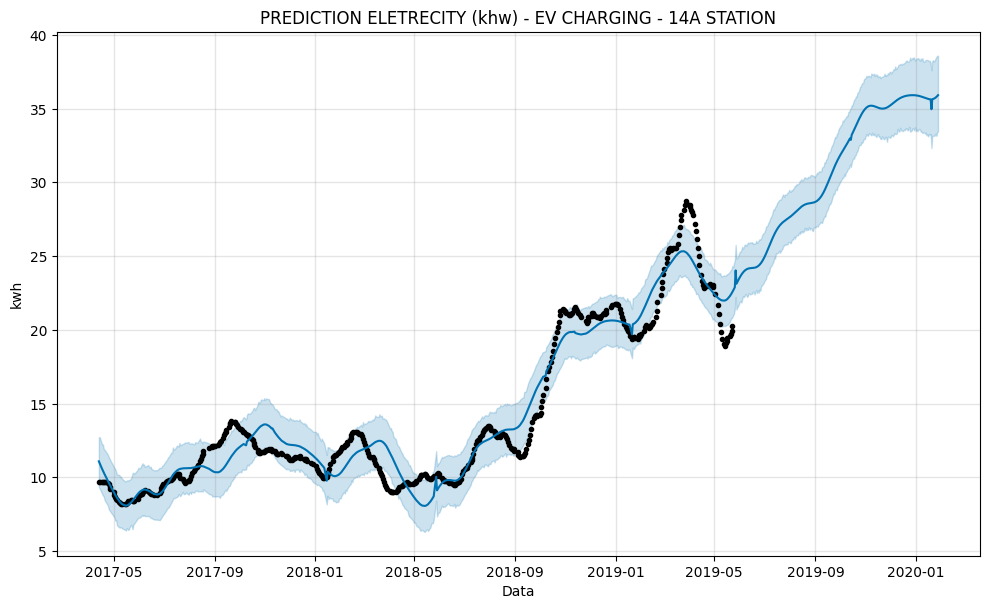

21:41:26 - cmdstanpy - INFO - Chain [1] start processing


data shape: (781, 2)


21:41:26 - cmdstanpy - INFO - Chain [1] done processing


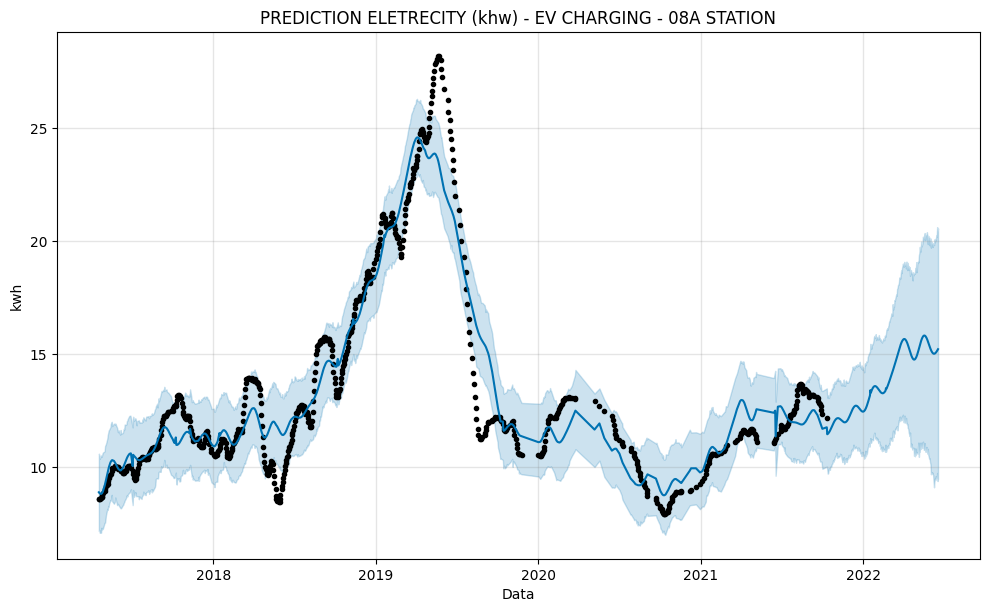

In [31]:
for station in time_series_df.keys():
    prophet_ts(time_series_df[station])

### ======================= TimeSeries - AUTOARIMA =======================

In [14]:
df_aa = df.copy() #Let's try auto_arima
df_aa.head()

,request_entry_time,energy_charged,station
2,2016-11-03,10.993141,03A
5,2016-11-04,7.877445,12B
6,2016-11-04,8.832178,02A
8,2016-11-04,4.367074,07B
10,2016-11-04,14.567150,07A


In [15]:
#Creating a dataframe for each garage and filtering a column of the total energy consumption
time_series_df_aa = {}

for id in df_aa['station'].unique():
    df_by_id = df_aa[df_aa['station'] == id]
    # auto_arima does not work with missing days in a daily dataset, so we will transform this data to monthly dataset
    df_by_id.set_index('request_entry_time', inplace=True)
    df_by_id = df_by_id.resample('M').sum()

    df_by_id['station'] = id

    time_series_df_aa[id] = df_by_id

In [16]:
time_series_df_aa['03A'] #just checking with 1 example 

,energy_charged,station
request_entry_time,,
2016-11-30,35.451352,03A
2016-12-31,56.769196,03A
2017-01-31,59.014191,03A
2017-02-28,163.676482,03A
2017-03-31,273.144280,03A
2017-04-30,177.527102,03A
2017-05-31,169.966486,03A
2017-06-30,229.379740,03A
2017-07-31,102.787304,03A


In [33]:
def auto_arima_ts(df):
    df_model = df.drop(['station'], axis=1)
    model=auto_arima(df_model,
                    start_p=0,
                    start_q=0,
                    d=0,
                    max_p=6,
                    max_q=6,
                    max_d=2,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=2, max_D=1, max_Q=2, max_order=5,
                    m=12,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)
    
    train_size = int(len(df_model) * 0.8) # 80% for training, 20% for testing
    train, test = df_model[:train_size], df_model[train_size:]

    model.fit(train)

    pred=model.predict(n_periods=60)
    pred=pd.DataFrame(pred,index=test.index, columns=['pred_aa'])

    plt.figure(figsize=(20,5))
    pd.concat([test,pred],axis=1).plot(figsize=(20,5))
    plt.xlabel('')
    plt.title(f'Previsões X Real -- {df.station[1]}',size=15)
    plt.xlabel("Data", size=15)
    plt.legend(['Valor Real','Previsão auto_arima']);

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=531.332, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=479.796, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=531.011, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=485.843, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=476.515, Time=1.86 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.77 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=477.638, Time=3.35 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=477.459, Time=2.06 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=479.462, Time=3.79 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=474.904, Time=

<Figure size 2000x500 with 0 Axes>

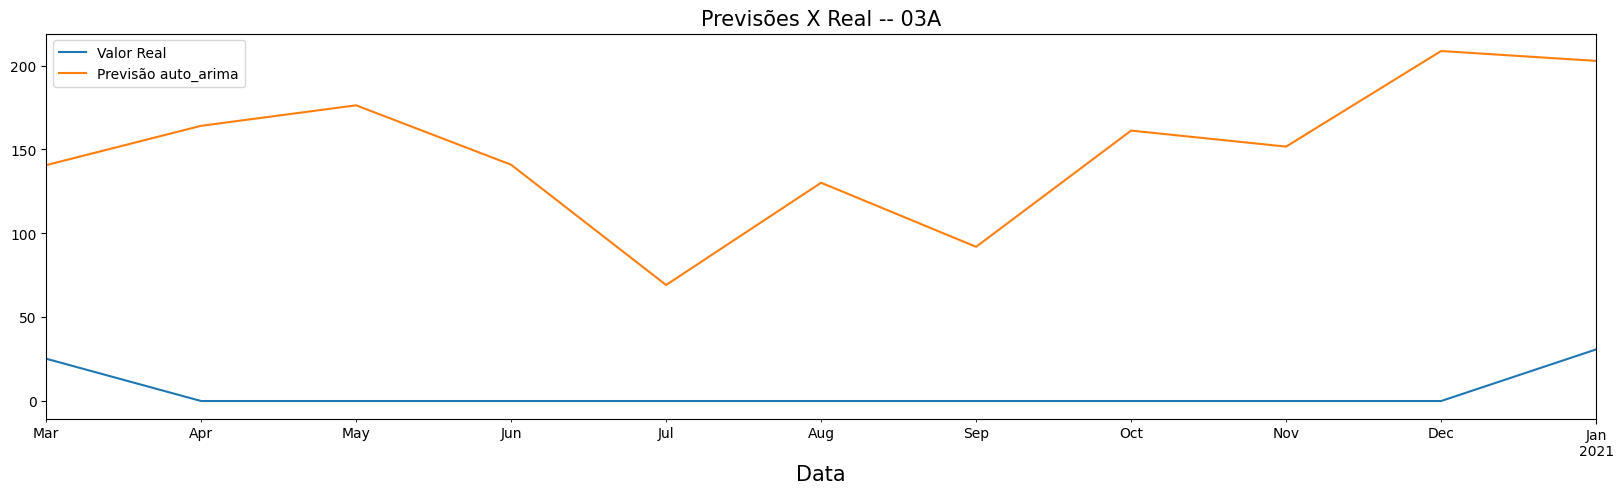

<Figure size 2000x500 with 0 Axes>

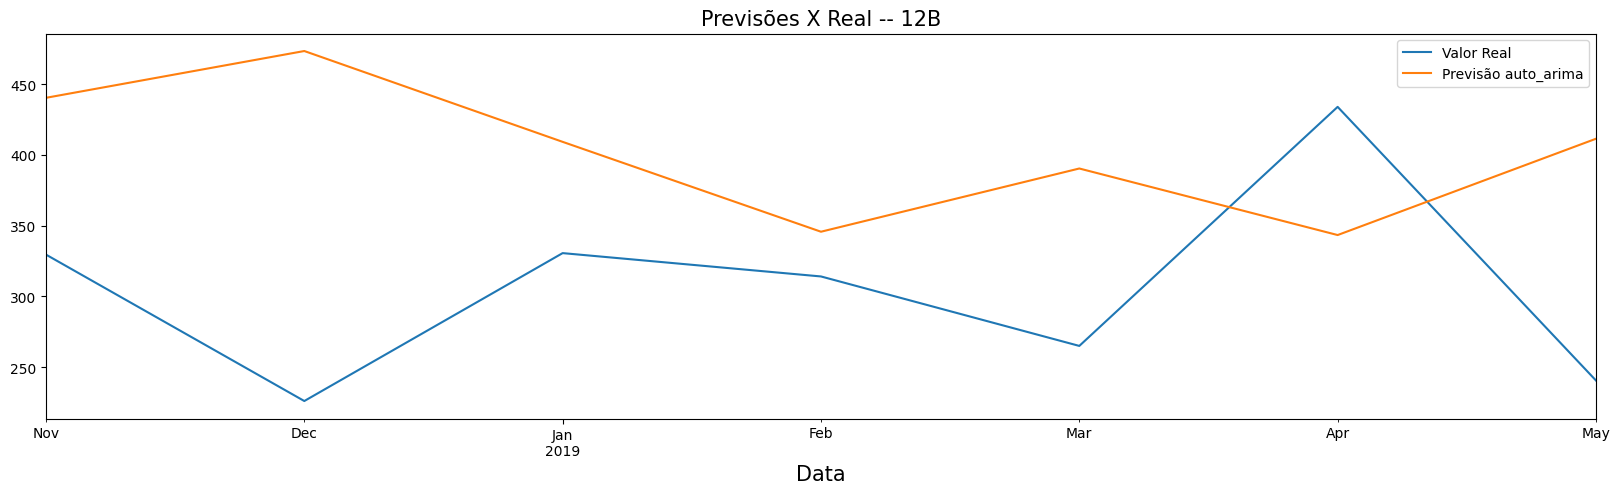

<Figure size 2000x500 with 0 Axes>

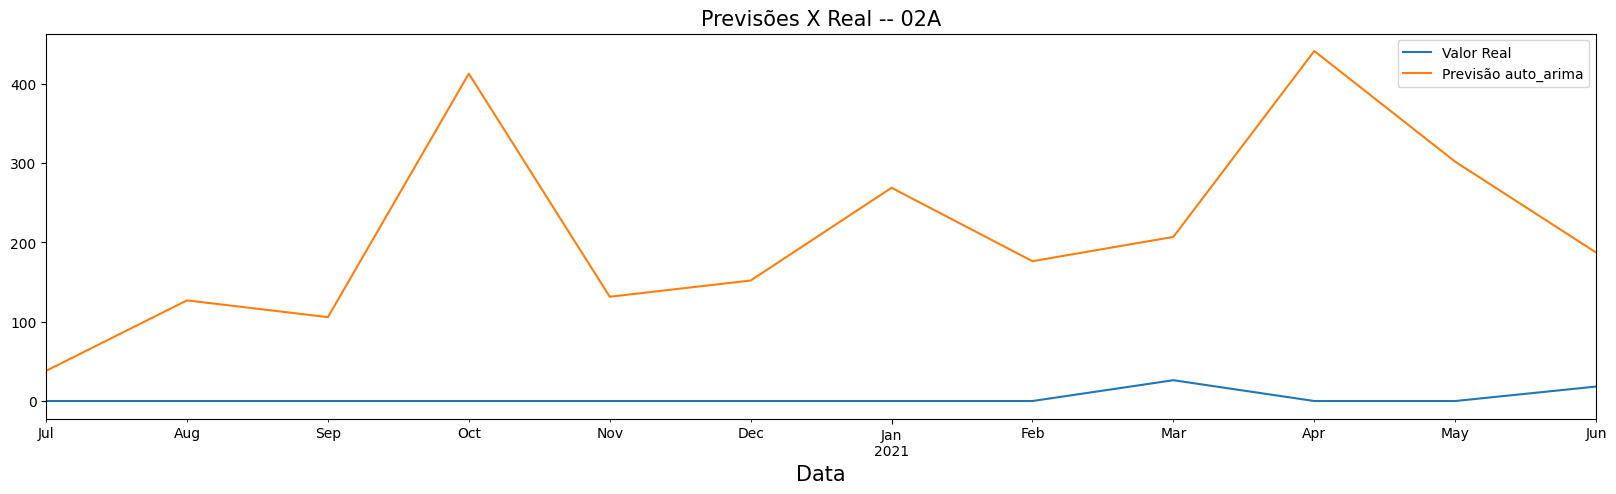

<Figure size 2000x500 with 0 Axes>

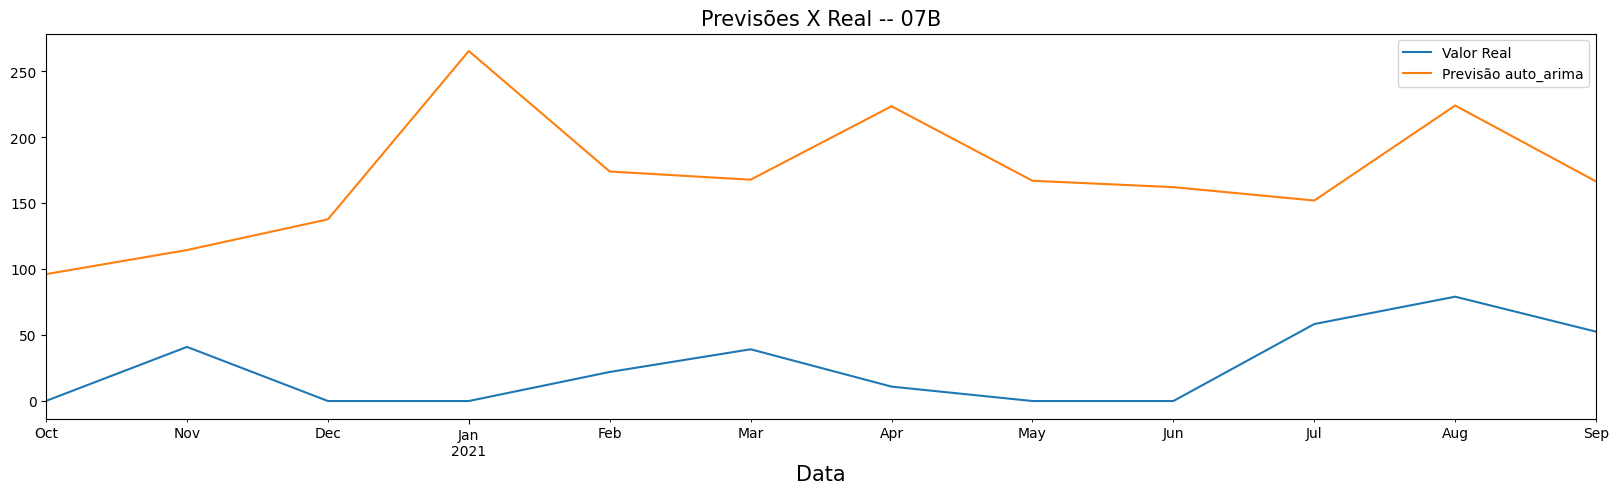

<Figure size 2000x500 with 0 Axes>

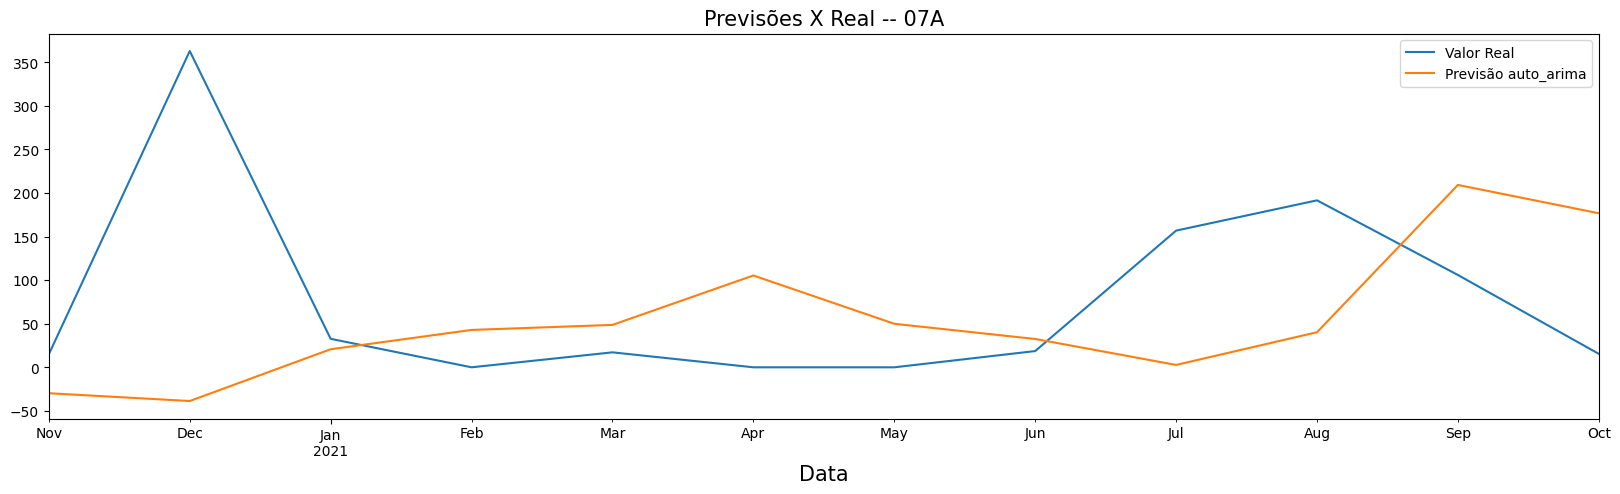

<Figure size 2000x500 with 0 Axes>

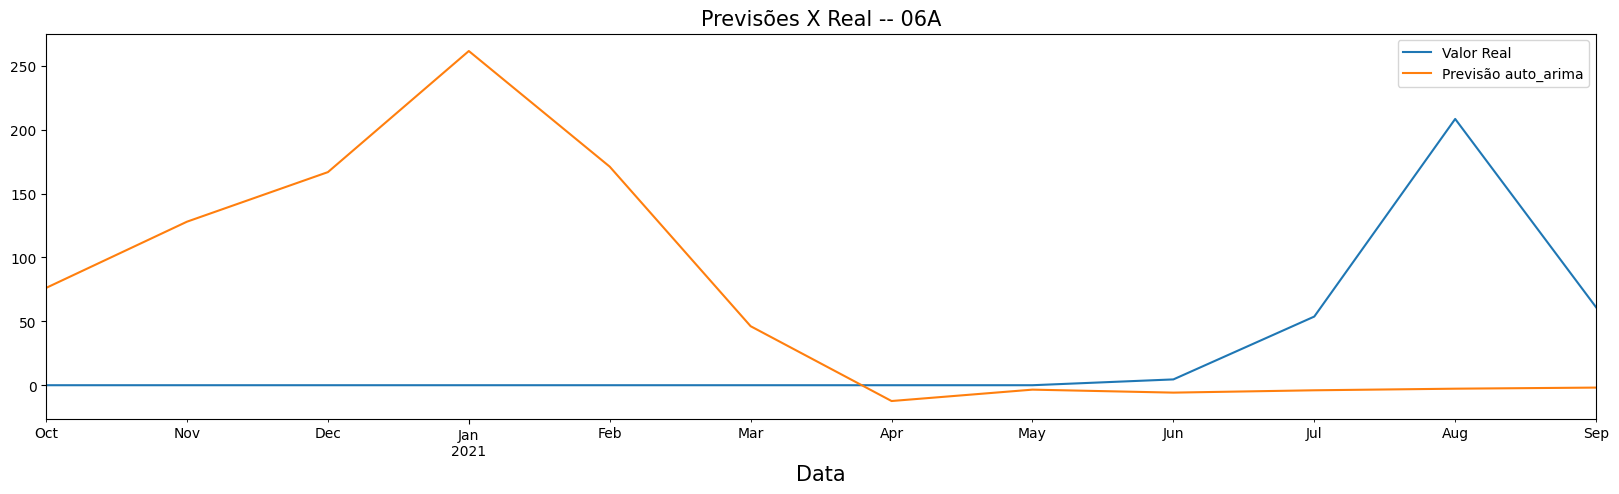

<Figure size 2000x500 with 0 Axes>

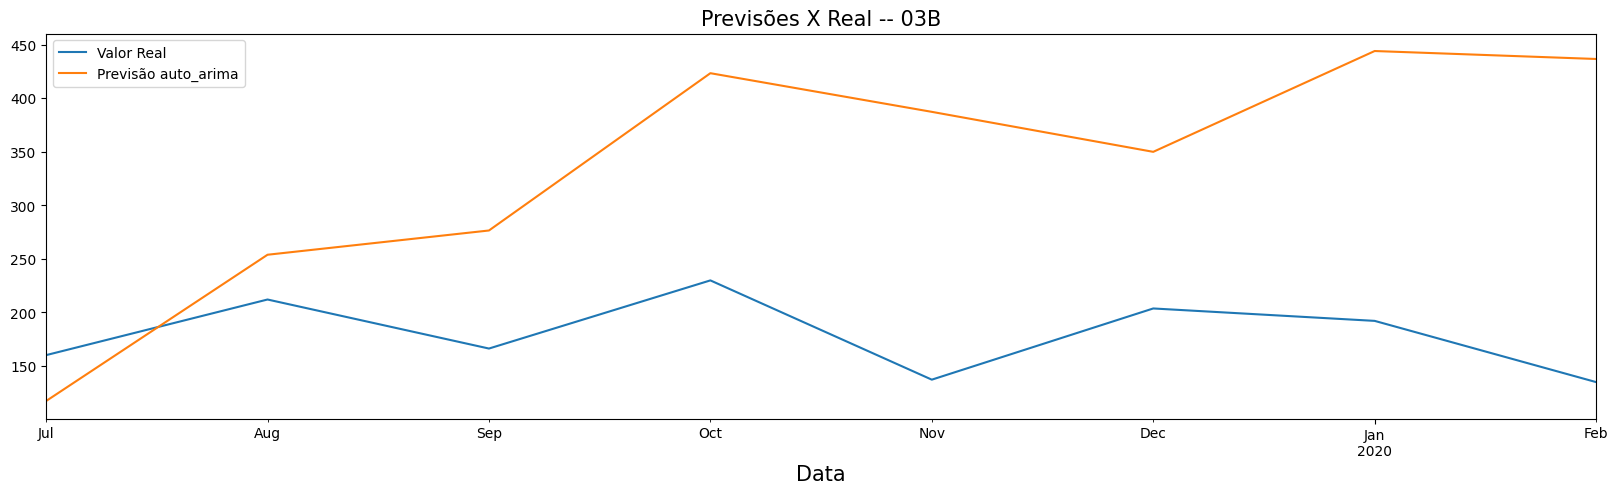

<Figure size 2000x500 with 0 Axes>

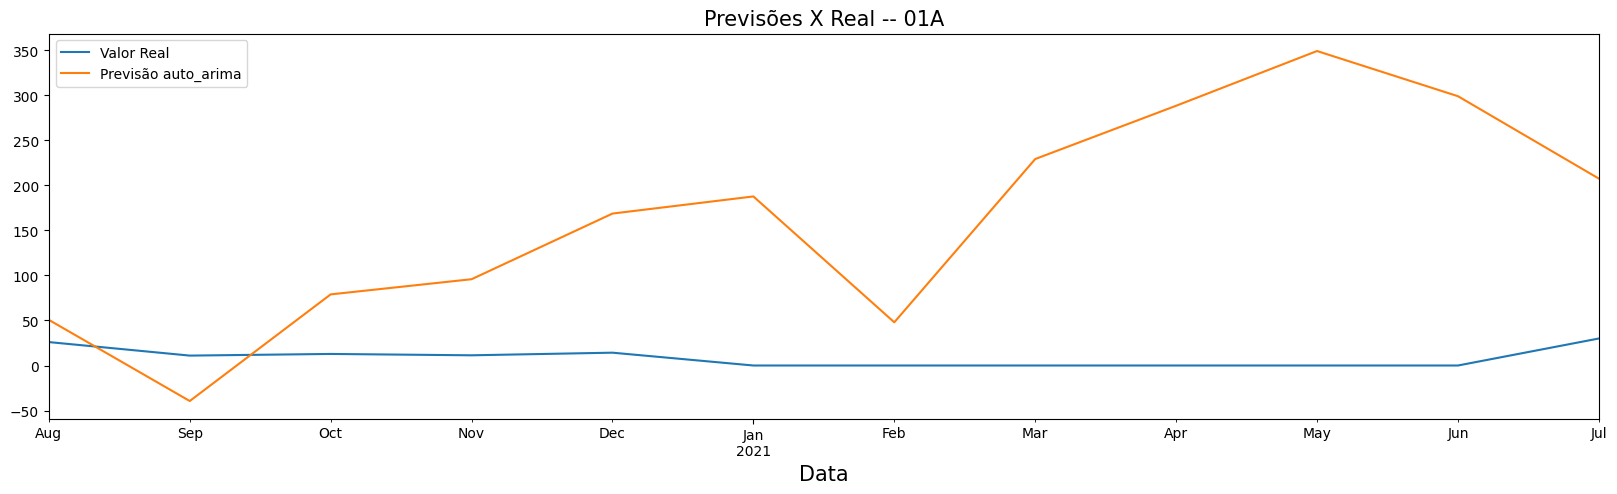

<Figure size 2000x500 with 0 Axes>

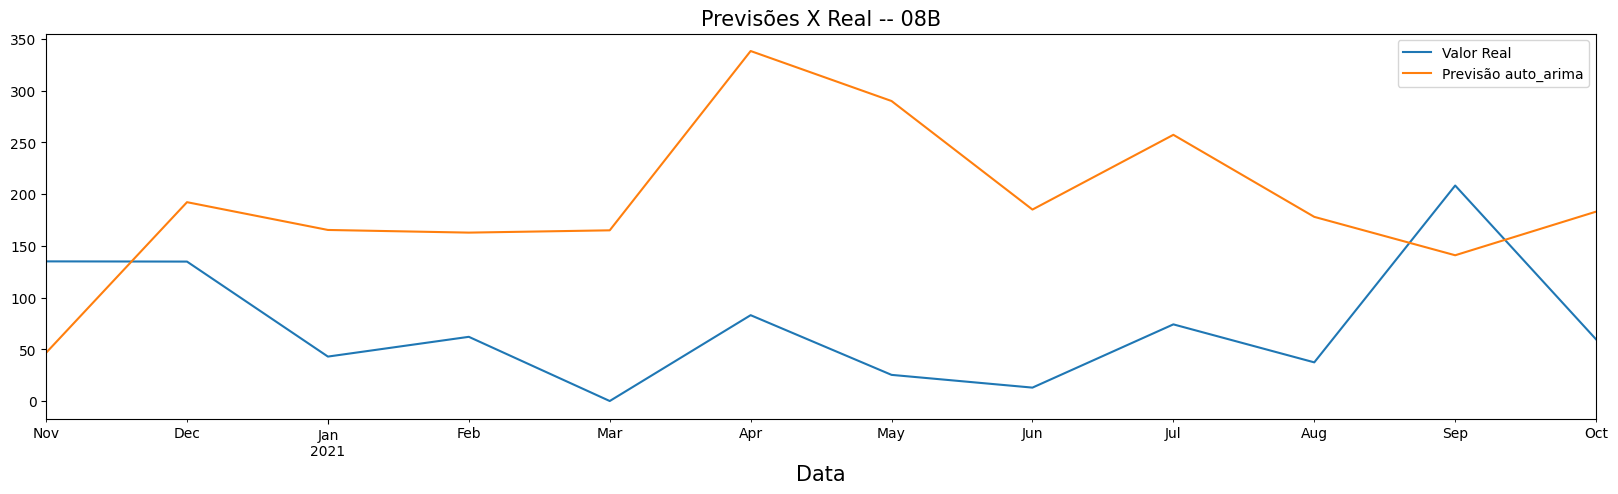

<Figure size 2000x500 with 0 Axes>

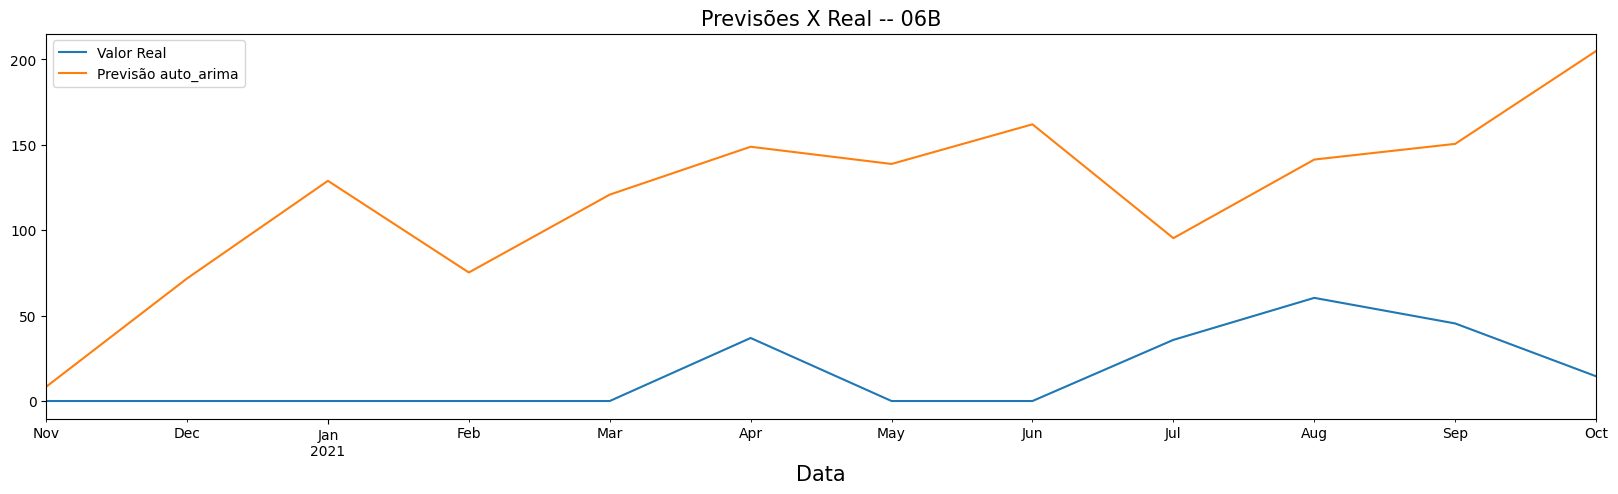

<Figure size 2000x500 with 0 Axes>

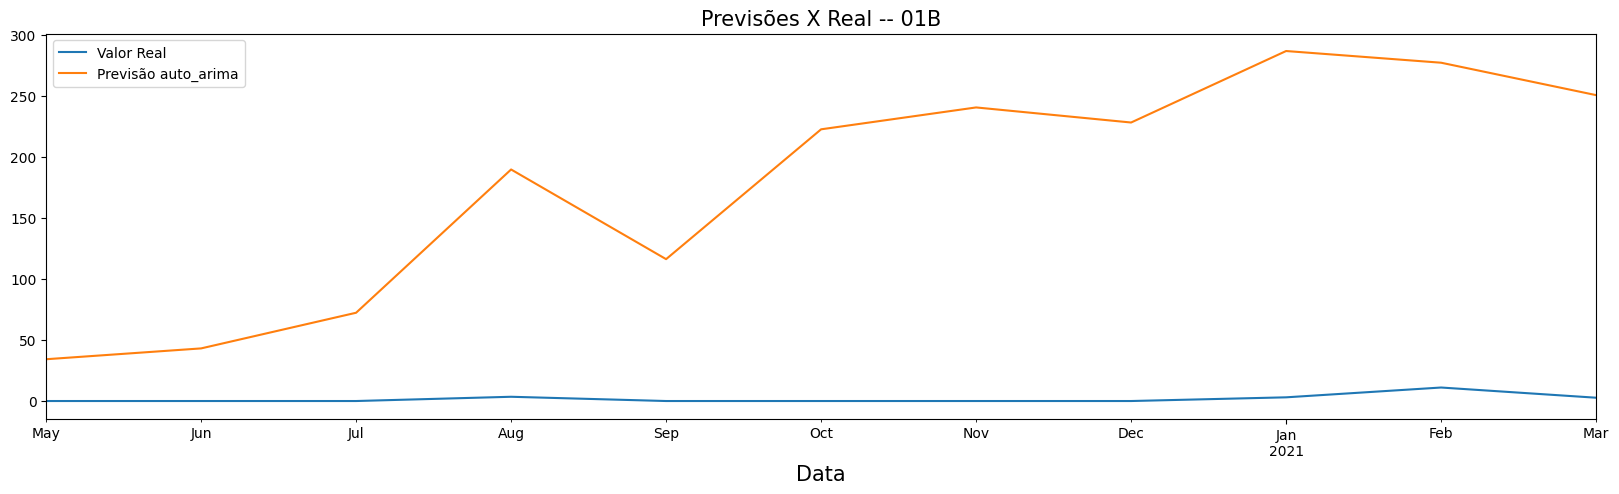

<Figure size 2000x500 with 0 Axes>

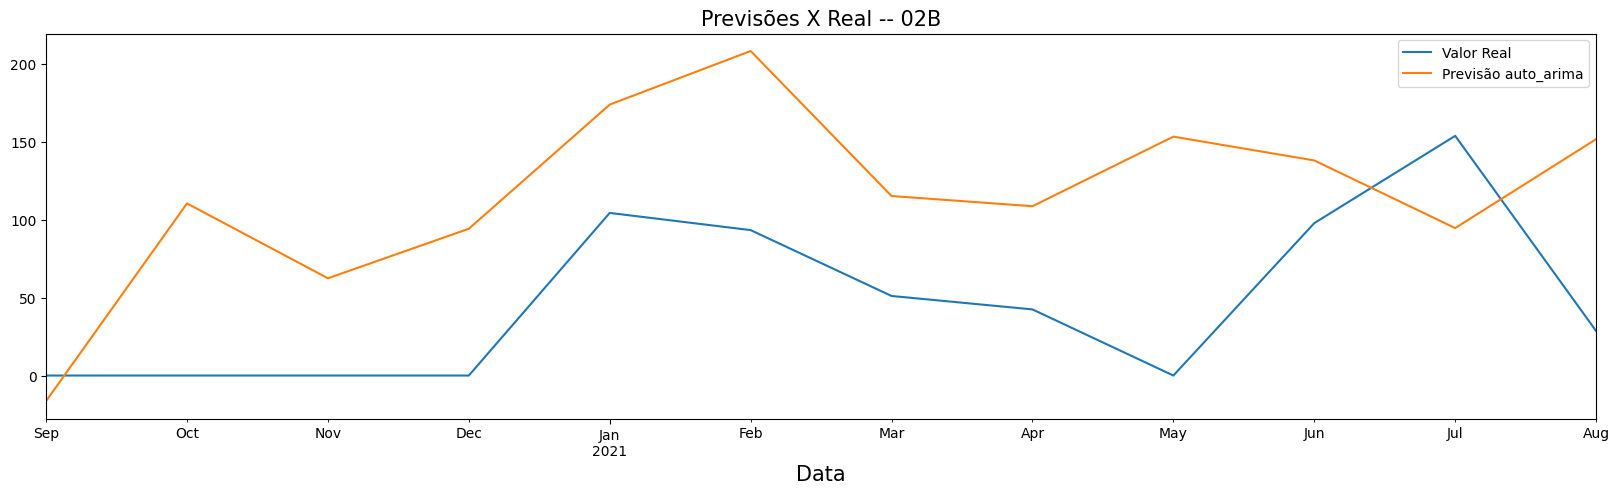

<Figure size 2000x500 with 0 Axes>

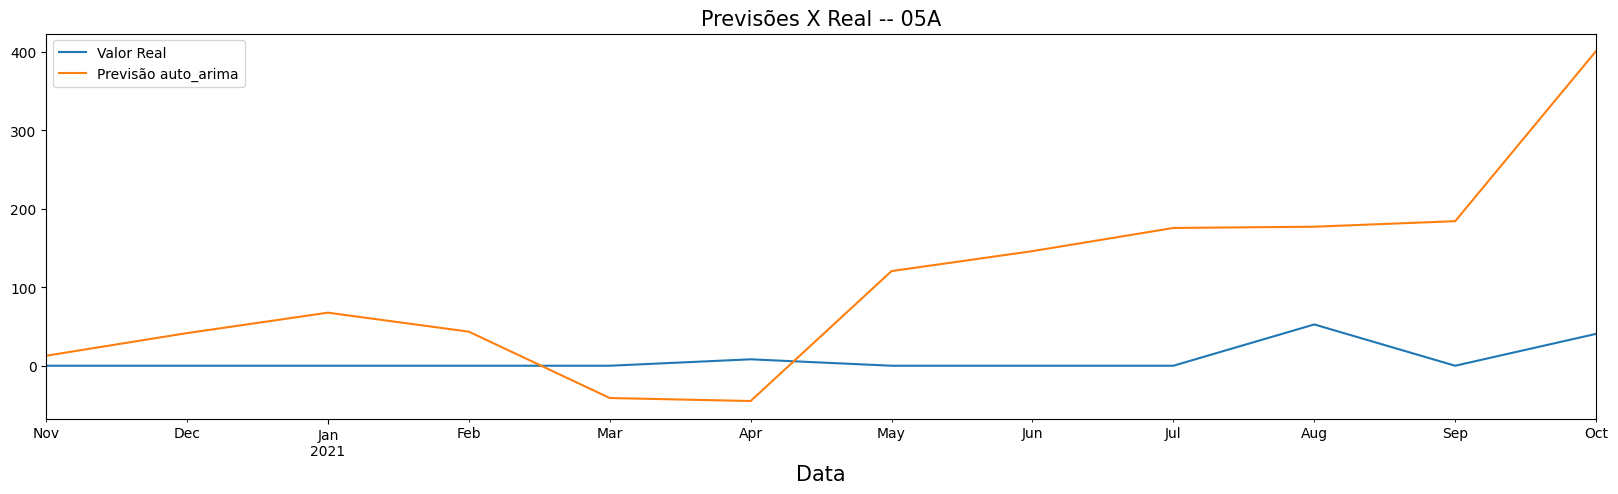

<Figure size 2000x500 with 0 Axes>

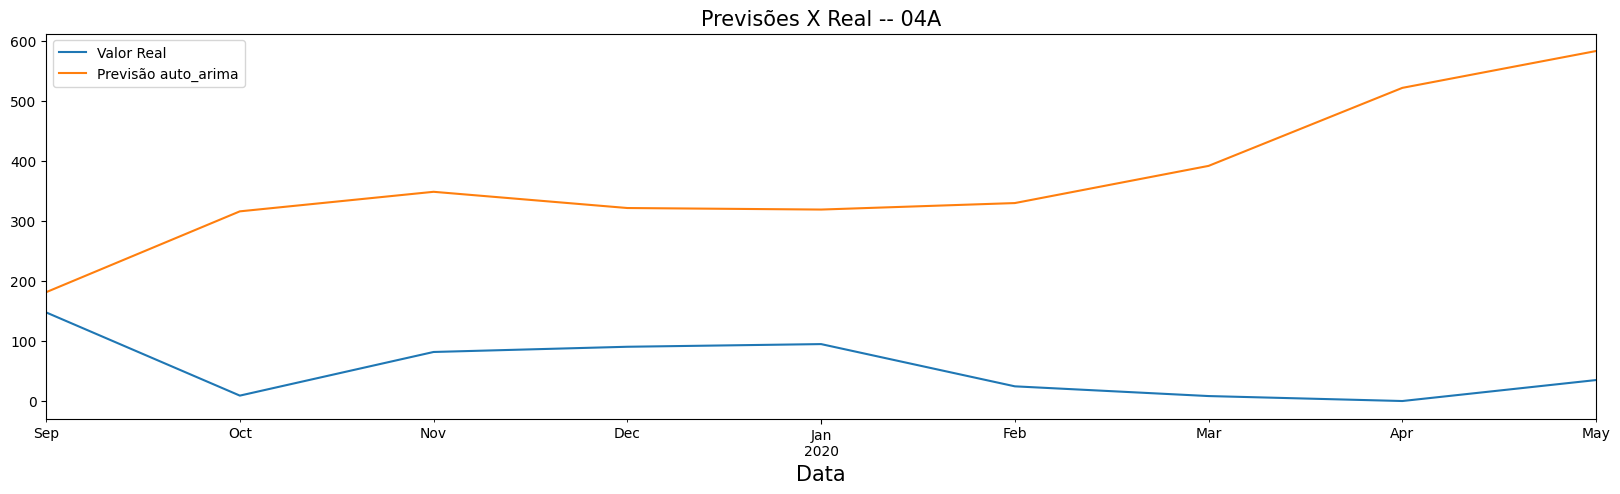

<Figure size 2000x500 with 0 Axes>

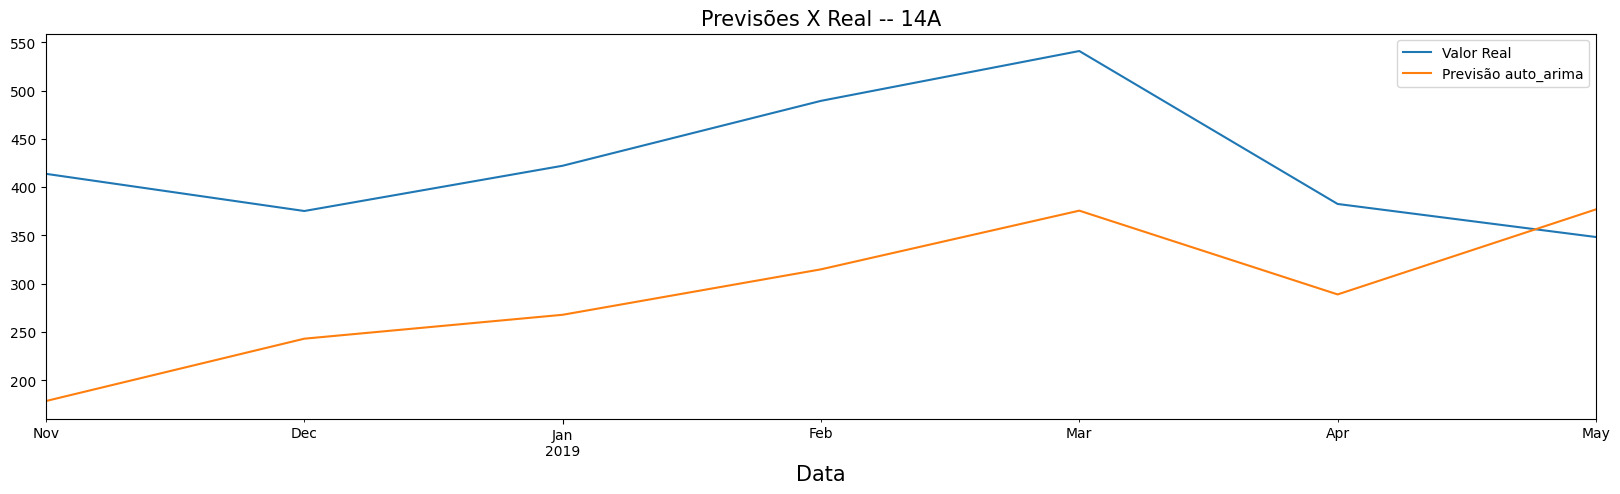

<Figure size 2000x500 with 0 Axes>

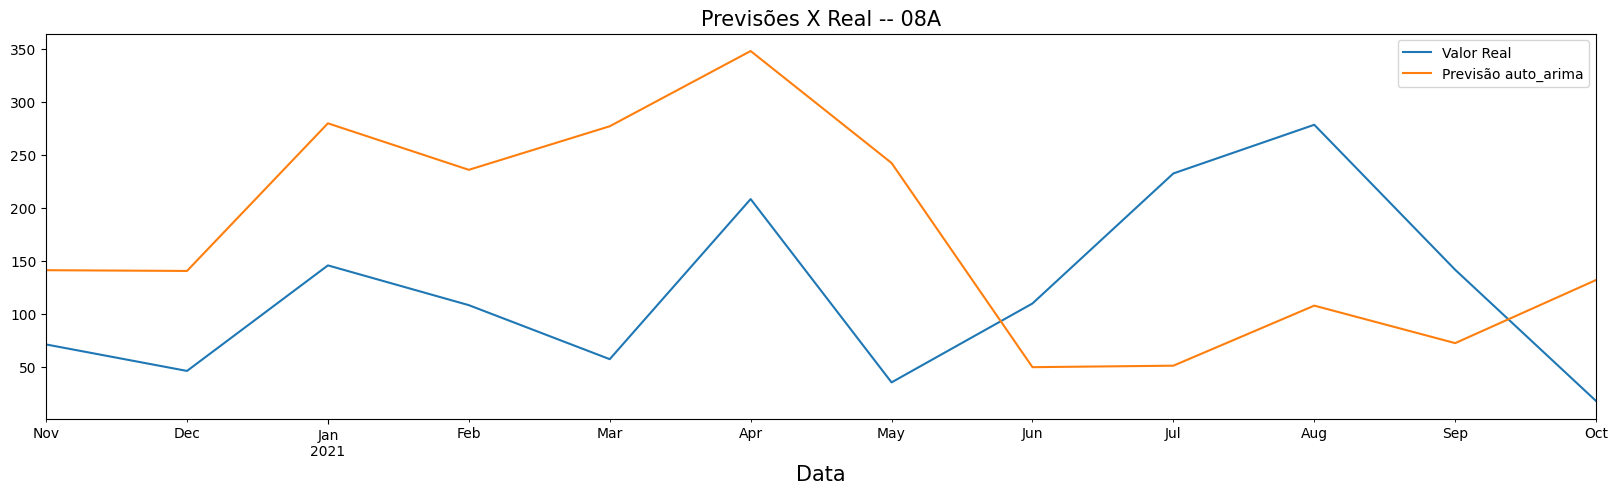

In [34]:
for station in time_series_df_aa.keys():
    auto_arima_ts(time_series_df_aa[station])